In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import cv2
import ast
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.utils.data as data
import torchvision
import json
import matplotlib.patches as patches

from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torchvision import transforms, datasets, models
from torch.autograd import Variable
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw

PATH = {
    'train': 'drive/My Drive/Object Detection/Wheat/train',
    'test': 'drive/My Drive/Object Detection/Wheat/test'
}

CSV = {
    'train': 'drive/My Drive/Object Detection/Wheat/train.csv',
    'sample_submission': 'drive/My Drive/Object Detection/Wheat/sample_submission.csv'
}

train = pd.read_csv(CSV['train'])
sample = pd.read_csv(CSV['sample_submission'])
print('Size of train data: ', train.shape)
print('Size of sample submission: ',sample.shape)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Size of train data:  (147793, 5)
Size of sample submission:  (10, 2)
cuda:0


In [2]:
def transform_data():
    transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform

In [3]:
class WheatDataset(data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.annotation = annotation
        self.transforms = transforms
        self.ids = os.listdir(root)
        self.anno_dict = self.make_dict()
        
    def make_dict(self):
        img_dict = {}
        with open(self.annotation) as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                if row[0] not in img_dict:
                    img_dict[row[0]] = [ast.literal_eval(row[3])]
                else:
                    img_dict[row[0]].append(ast.literal_eval(row[3]))
            return img_dict
    
    def __getitem__(self, index):
        
        
        #Open annotation file in json type
        obj_name = list(self.anno_dict.keys())[index]
        obj_boxes = self.anno_dict[obj_name]
        img_id = Image.open(os.path.join(self.root,obj_name+'.jpg'))
        
        num_obj = len(obj_boxes)
        boxes = []
        labels = []
        
        #Read in bounding boxes cordinate and labels
        for i in range(num_obj):
            xmin =  int(obj_boxes[i][0])
            ymin =  int(obj_boxes[i][1])
            xmax =  xmin + int(obj_boxes[i][2])
            ymax =  ymin + int(obj_boxes[i][3])
            label = 0
            boxes.append([xmin,ymin,xmax,ymax])
            labels.append(label)
        
        #Tensorize 
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = torch.LongTensor(labels)
        index = torch.Tensor([index])
        iscrowd = torch.zeros((num_obj,), dtype=torch.int64)
        
        #Create dict of annotation for easy access
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = index
        my_annotation["iscrowd"] = iscrowd
        my_annotation["area"] = area
        
        if self.transforms is not None:
            img = self.transforms()(img_id)
        
        return img, my_annotation
    
    def __len__(self):
        return len(self.anno_dict)

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [33]:
dataset = WheatDataset(PATH['train'],CSV['train'],transforms = transform_data)
print(f'Number of training samples: {len(dataset)}')
indices = torch.randperm(len(dataset)).tolist()
train = torch.utils.data.Subset(dataset,indices[:-665])
print(len(train))
test = torch.utils.data.Subset(dataset,indices[-665:])
print(len(test))
data_loader = data.DataLoader(train, batch_size = 4, shuffle = True, collate_fn=collate_fn, num_workers = 4, pin_memory= True)
test_loader = data.DataLoader(test, batch_size= 4, shuffle = False, collate_fn= collate_fn, num_workers= 4, pin_memory= True)


Number of training samples: 3373
2708
665


In [18]:
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_show = img.cpu().numpy().squeeze().transpose((1,2,0))
    img_show = (img_show*std + mean)
    img_show = np.clip(img_show, 0 ,1)
    return img_show

In [19]:
for id,(img,anno) in enumerate(data_loader):
    print('Id: ', id)
    print('Img: ', img)
    print('Anno: ',anno)
    break

Id:  0
Img:  [tensor([[[-1.8439, -1.8268, -1.7925,  ...,  0.5364,  0.3138,  0.2282],
         [-1.8268, -1.8097, -1.7925,  ...,  0.4851,  0.2967,  0.2111],
         [-1.8268, -1.8097, -1.7754,  ...,  0.4851,  0.3481,  0.2796],
         ...,
         [ 1.0673,  1.0331,  1.2899,  ..., -1.6384, -1.6042, -1.5870],
         [ 1.4954,  1.4098,  1.5468,  ..., -1.6555, -1.6384, -1.6213],
         [ 1.4954,  1.4098,  1.5639,  ..., -1.6727, -1.6555, -1.6384]],

        [[-1.7731, -1.7556, -1.7206,  ...,  0.4678,  0.2227,  0.1176],
         [-1.7556, -1.7381, -1.6856,  ...,  0.4153,  0.2052,  0.1001],
         [-1.7206, -1.7031, -1.6681,  ...,  0.4153,  0.2577,  0.1877],
         ...,
         [ 1.0980,  1.0630,  1.3431,  ..., -1.3880, -1.3529, -1.3354],
         [ 1.5357,  1.4482,  1.6057,  ..., -1.4055, -1.3880, -1.3704],
         [ 1.5357,  1.4657,  1.6232,  ..., -1.4230, -1.4055, -1.3880]],

        [[-1.6302, -1.6127, -1.5779,  ..., -0.1487, -0.3404, -0.4450],
         [-1.6127, -1.5953, -1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


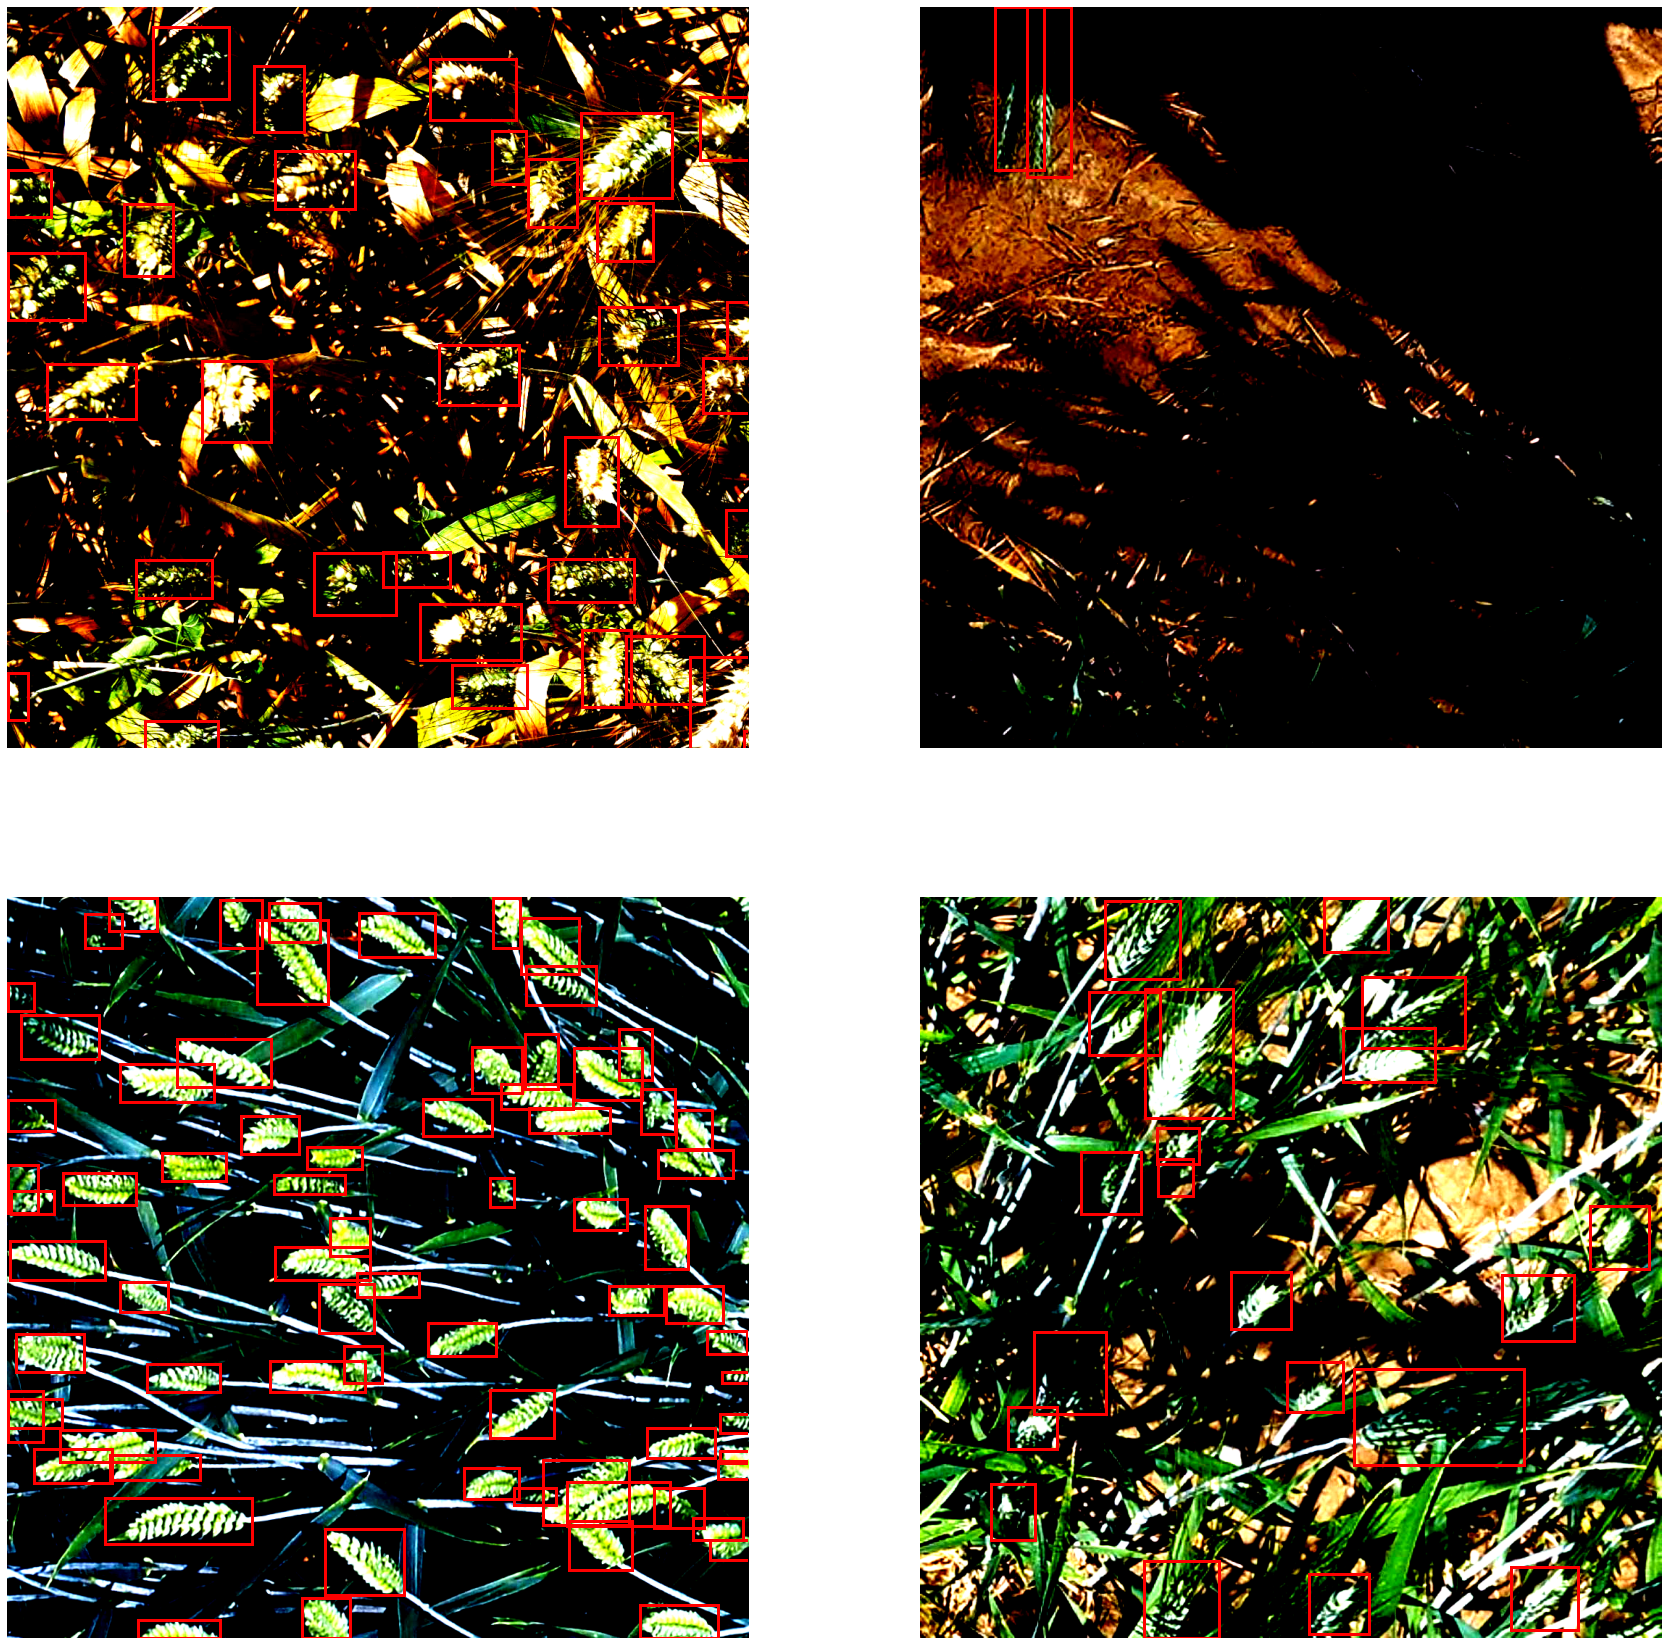

In [20]:
images, labels = next(iter(data_loader))

def view(images, labels,k):
    figure = plt.figure(figsize=(30,30))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    images=list(images)
    labels=list(labels)
    for i in range(k):
        out=torchvision.utils.make_grid(images[i])
        inp=out.cpu().numpy().transpose((1,2,0))
        inp=np.array(std)*inp+np.array(mean)
        inp=np.clip(inp,0,1)  
        ax = figure.add_subplot(2,2, i + 1)
        ax.imshow(images[i].cpu().numpy().transpose((1,2,0)))
        l=labels[i]['boxes'].cpu().numpy()
        l[:,2]=l[:,2]-l[:,0]
        l[:,3]=l[:,3]-l[:,1]
        for j in range(len(l)):
            ax.add_patch(patches.Rectangle((l[j][0],l[j][1]),l[j][2],l[j][3],fill = False, ec= 'red', lw = 3)) 
        plt.axis('off')
    plt.show()
view(images,labels,4)


def visualize_images():
    f, ax = plt.subplots(1, 1,figsize = (10, 10))
    for id, (img,anno) in enumerate(data_loader):
        if id == 1:
            break
        for box in anno[id]['boxes']:
            rect = patches.Rectangle((box[0], box[1]),box[2] - box[0],
                                     box[3]- box[1],fill = False, ec= 'red', lw = 3)
            ax.add_patch(rect)
        
        image = imshow(img[id]) 
        plt.axis('off')
        plt.imshow(image)
    plt.show()
#visualize_images()

In [21]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained= True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(device)
num_epochs = 5

print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [22]:
def train(model, data_loader):
    loss_list = []
    optimizer = torch.optim.SGD(model.parameters(), lr = 1e-4, momentum= 0.9)
    for epoch in range(num_epochs):
        total_loss = 0.0
        model.train()
        for id, (img, anno) in enumerate(tqdm(data_loader)):
            optimizer.zero_grad()
            images = list(image.to(device) for image in img)
            targets = [{k: v.to(device) for k,v in t.items()} for t in anno]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

            losses.backward()
            optimizer.step()

            if (id%100 == 0 and id!=0) or id == len(data_loader) - 1:
                print(f'Epoch: {epoch + 1} | Iteration: {id}/{len(data_loader)} | Loss: {losses: .3f}')

        total_loss /= len(data_loader)
        loss_list.append(total_loss)
        torch.save(model.state_dict(), f'drive/My Drive/Object Detection/Wheat/model/fasterrcnn_resnet50_fpn_update_{epoch+1}')
        print(f'Epoch: [{epoch+1}/{num_epochs}] | Training Loss: {total_loss: .3f}') 
    
    print('Done!')
    return model, loss_list

In [23]:
model, loss_list = train(model, data_loader)

Epoch: 1 | Iteration: 100/677 | Loss:  0.286
Epoch: 1 | Iteration: 200/677 | Loss:  0.358
Epoch: 1 | Iteration: 300/677 | Loss:  0.290
Epoch: 1 | Iteration: 400/677 | Loss:  0.246
Epoch: 1 | Iteration: 500/677 | Loss:  0.298
Epoch: 1 | Iteration: 600/677 | Loss:  0.205
Epoch: 1 | Iteration: 676/677 | Loss:  0.397

Epoch: [1/5] | Training Loss:  0.307


Epoch: 2 | Iteration: 100/677 | Loss:  0.430
Epoch: 2 | Iteration: 200/677 | Loss:  0.204
Epoch: 2 | Iteration: 300/677 | Loss:  0.132
Epoch: 2 | Iteration: 400/677 | Loss:  0.188
Epoch: 2 | Iteration: 500/677 | Loss:  0.161
Epoch: 2 | Iteration: 600/677 | Loss:  0.159
Epoch: 2 | Iteration: 676/677 | Loss:  0.421

Epoch: [2/5] | Training Loss:  0.225


Epoch: 3 | Iteration: 100/677 | Loss:  0.201
Epoch: 3 | Iteration: 200/677 | Loss:  0.127
Epoch: 3 | Iteration: 300/677 | Loss:  0.223
Epoch: 3 | Iteration: 400/677 | Loss:  0.216
Epoch: 3 | Iteration: 500/677 | Loss:  0.198
Epoch: 3 | Iteration: 600/677 | Loss:  0.362
Epoch: 3 | Iteration: 676/677 | Loss:  0.172

Epoch: [3/5] | Training Loss:  0.203


Epoch: 4 | Iteration: 100/677 | Loss:  0.157
Epoch: 4 | Iteration: 200/677 | Loss:  0.199
Epoch: 4 | Iteration: 300/677 | Loss:  0.122
Epoch: 4 | Iteration: 400/677 | Loss:  0.156
Epoch: 4 | Iteration: 500/677 | Loss:  0.179
Epoch: 4 | Iteration: 600/677 | Loss:  0.186
Epoch: 4 | Iteration: 676/677 | Loss:  0.225

Epoch: [4/5] | Training Loss:  0.193


Epoch: 5 | Iteration: 100/677 | Loss:  0.159
Epoch: 5 | Iteration: 200/677 | Loss:  0.223
Epoch: 5 | Iteration: 300/677 | Loss:  0.221
Epoch: 5 | Iteration: 400/677 | Loss:  0.259
Epoch: 5 | Iteration: 500/677 | Loss:  0.248
Epoch: 5 | Iteration: 600/677 | Loss:  0.177
Epoch: 5 | Iteration: 676/677 | Loss:  0.223

Epoch: [5/5] | Training Loss:  0.184
Done!


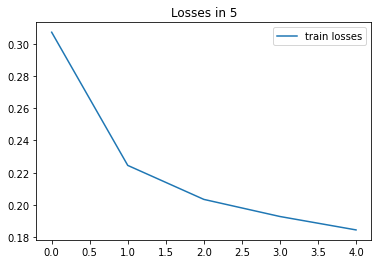

In [24]:
def plot_losses(loss_list):
    plt.plot(np.arange(num_epochs), loss_list, label = 'train losses')
    plt.title(f'Losses in {num_epochs}')
    plt.legend()
    plt.show()
plot_losses(loss_list)

In [30]:
model.load_state_dict(torch.load(f'drive/My Drive/Object Detection/Wheat/model/fasterrcnn_resnet50_fpn_update_{num_epochs}'))

<All keys matched successfully>

In [34]:
images, annos = next(iter(test_loader))
images = list(image.to(device) for image in images)
print(images)
targets = [{k: v.to(device) for k, v in t.items()} for t in annos]
model.eval()
output = model(images)
print(output)
with torch.no_grad():
    view(images, output, 4)

[tensor([[[-1.6384, -1.6042, -1.6213,  ..., -1.7069, -1.7069, -1.7240],
         [-1.6384, -1.6213, -1.6213,  ..., -1.7240, -1.7240, -1.7412],
         [-1.6042, -1.5870, -1.6042,  ..., -1.7412, -1.7412, -1.7583],
         ...,
         [-1.8097, -1.8097, -1.8268,  ..., -1.4158, -0.7993, -0.0116],
         [-1.8782, -1.8610, -1.8439,  ..., -1.3987, -0.8678, -0.1999],
         [-1.9124, -1.8610, -1.8268,  ..., -1.3987, -1.0048, -0.4739]],

        [[-1.4580, -1.4230, -1.4405,  ..., -1.4230, -1.4230, -1.4405],
         [-1.4580, -1.4405, -1.4405,  ..., -1.4405, -1.4405, -1.4580],
         [-1.4230, -1.4055, -1.4230,  ..., -1.4580, -1.4580, -1.4755],
         ...,
         [-1.8081, -1.8081, -1.8256,  ..., -1.3880, -0.7577,  0.0476],
         [-1.8782, -1.8606, -1.8431,  ..., -1.3704, -0.8277, -0.1450],
         [-1.9132, -1.8606, -1.8256,  ..., -1.3704, -0.9678, -0.4251]],

        [[-1.3513, -1.3164, -1.3339,  ..., -1.2641, -1.2641, -1.2816],
         [-1.3513, -1.3339, -1.3339,  ..., -

In [ ]:
# def visualize_test(model, num_pic = 10):
#     min_score = 0.3
#     fig = plt.figure(figsize = (25, 12))
#     path = os.listdir(PATH['test'])
#     for id, source in enumerate(path):
#         fig.add_subplot(2, 5, id + 1)

#         img = Image.open(os.path.join(PATH['test'], source))
        
#         pred = test_image(model, img)
#         #print(f'Prediction of {source} is: {pred}')
#         scores = pred[0]['scores']
#         scores = scores[scores >= min_score]
#         num_scores = len(scores)

#         boxes = pred[0]['boxes'][:num_scores]
#         labels= pred[0]['labels'][:num_scores]
#         plt.imshow(img)
#         ax = plt.gca()
#         plt.axis('off')
#         plt.title(f'Source: {source}')
#         for box, label, score in zip(boxes, labels, scores):
#             xmin,ymin,xmax,ymax = box
#             label = str(label.cpu().numpy())

#             rect= patches.Rectangle((xmin,ymin),xmax- xmin, ymax- ymin, color = 'red', lw = 3, fill =False)

#             plt.text(x, y- 2, label, color ='red', fontsize = 10, fontweight = 'bold')
#             ax.add_patch(text)

#             # prevent rom overload
#             if torch.cuda.is_available():
#                 del xmin, ymin, xmax, ymax, box, label, score
#                 torch.cuda.empty_cache()
#         if torch.cuda.is_available():
#             del pred, boxes, labels, scores
#             torch.cuda.empty_cache()
#     plt.show()
# visualize_test(model, 10)